In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data_path  = 'data/'

### Loading and exploring dataset

In [5]:
df = pd.read_csv(data_path + 'company_pairs.csv')

In [6]:
df.head(5)

,Unnamed: 0,entity_1,entity_2,tag
0,3137667,preciform A.B,Preciform AB,1
1,5515816,degener staplertechnik vertriebs-gmbh,Irshim,0
2,215797,Alltel South CaroliNA Inc,alltel south carolina INC.,1
3,1004621,cse Corporation,Cse Corp,1
4,1698689,Gruppo D Motors Srl,gruppo d motors Sociedad de Resposabilidad Lim...,1


In [596]:
#count nan
print(df.isna().sum())

Unnamed: 0    0
entity_1      0
entity_2      0
tag           0
dtype: int64


In [597]:
#check if classes are balanced
df_count = df.groupby('tag')['tag'].count()
print(df_count)

tag
0    4162006
1    2880840
Name: tag, dtype: int64


In [598]:
# ckeck unique company names
df.nunique()

Unnamed: 0    7042846
entity_1      3074138
entity_2      3072024
tag                 2
dtype: int64

### Check alphabet

In [599]:
df_subset_alph = df.iloc[::,1:3]
alphabet = df_subset_alph.agg(lambda x: set(''.join(x)), axis = 0)

In [600]:
print('First column alphabet = ', sorted(list(alphabet['entity_1'])))
print('Second column alphabet = ', sorted(list(alphabet['entity_2'])))

First column alphabet =  [' ', '!', '#', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '=', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}', '²', 'à', 'ç', 'é', 'í', 'ó', 'ô', 'ö', 'ü', 'ý', 'ć', 'č', 'š', '‘', '’']
Second column alphabet =  [' ', '!', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '=', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}', '²', 'à', 'ç', 

In [601]:
len(alphabet[0])

101

## Performing data cleaning and feature generation on a subset of data

In [602]:
df_subset = df.iloc[:50000]
df_subset.head(5)

,Unnamed: 0,entity_1,entity_2,tag
0,3137667,preciform A.B,Preciform AB,1
1,5515816,degener staplertechnik vertriebs-gmbh,Irshim,0
2,215797,Alltel South CaroliNA Inc,alltel south carolina INC.,1
3,1004621,cse Corporation,Cse Corp,1
4,1698689,Gruppo D Motors Srl,gruppo d motors Sociedad de Resposabilidad Lim...,1


In [603]:
df_count = df_subset.groupby('tag')['tag'].count()
print(df_count)

tag
0    29576
1    20424
Name: tag, dtype: int64


### Cleaning

#### Using standart pipeline for string cleaning:
1. UNICODE special symbols normalization
2. Converting all symbols to lowercase
3. Replacing all non-alphanumeric symbols with spaces
4. Deleting extra spaces

#### Word-order
To account for possible mixes in word ordering, the strings are sorted by words


In [604]:
import unicodedata
import re

""" Normalise (normalize) unicode data in Python to remove umlauts, accents etc. """
def normalize_unicode_to_ascii(data):

    normal = unicodedata.normalize('NFKD', data).encode('ASCII', 'ignore')
    val = normal.decode("utf-8")
    val = val.lower()
    # remove special characters
    val = re.sub('[^A-Za-z0-9. ]+', ' ', val)
    # remove multiple spaces
    val = re.sub(' +', ' ', val)
    # remove dots - was added after exploring the wrong predictions
    val = re.sub('\.+', '', val)
    return val

def clean_and_sort_words(data):
    normal_data = normalize_unicode_to_ascii(data)
    sorted_words = normal_data.split(' ')
#     sorted_words = sorted(normal_data.split(' '))
    
    # replacing typical additions with acronyms
    for i in range(len(sorted_words)):
        if sorted_words[i][0:6] == 'incorp':
            sorted_words[i] = 'inc'
            
        elif sorted_words[i][0:5] == 'limit':
            sorted_words[i] = 'ltd'
        elif sorted_words[i][0:5] == 'liabi':
            sorted_words[i] = ''
        elif sorted_words[i][0:5] == 'llc':
            sorted_words[i] = 'ltd'
            
            
        elif sorted_words[i][0:6] == 'techno':
            sorted_words[i] = 'tech'
        elif sorted_words[i][0:5] == 'coltd':
            sorted_words[i] = 'co ltd'

    res = re.sub(' +', ' ', ' '.join(sorted_words))
    return res

In [605]:
def clean_columns_df(df_init):
    df_init['clean_entity_1'] = df_init['entity_1'].apply(clean_and_sort_words)
    df_init['clean_entity_2'] = df_init['entity_2'].apply(clean_and_sort_words)

In [606]:
clean_columns_df(df_subset)

In [607]:
df_subset[['clean_entity_1', 'clean_entity_2']].head(4)

,clean_entity_1,clean_entity_2
0,preciform ab,preciform ab
1,degener staplertechnik vertriebs gmbh,irshim
2,alltel south carolina inc,alltel south carolina inc
3,cse corporation,cse corp


In [608]:
df_alph = df_subset.iloc[::,4:6]
alphabet = df_alph.agg(lambda x: set(''.join(x)), axis = 1)
fs = set()
for row in alphabet:
    fs = fs | row
print(fs)

{'a', '9', '8', 'r', 'p', 'w', 'd', 'g', 'l', 'f', 'o', 'z', '2', 'n', ' ', 'b', '3', 'j', 'y', '7', '4', 'u', 'e', 'h', '0', 'c', 'i', '6', '5', 'q', 't', 'x', 's', '1', 'm', 'v', 'k'}


#### most popular word count

In [609]:
from collections import defaultdict
word_count_dict = defaultdict(int)

for row in range(len(df_subset.index)):

    company1 = df_subset.iloc[row]['clean_entity_1'].split(' ')
    company2 = df_subset.iloc[row]['clean_entity_1'].split(' ')
    
    for word in company1:
        word_count_dict[word] += 1
    for word in company2:
        word_count_dict[word] += 1

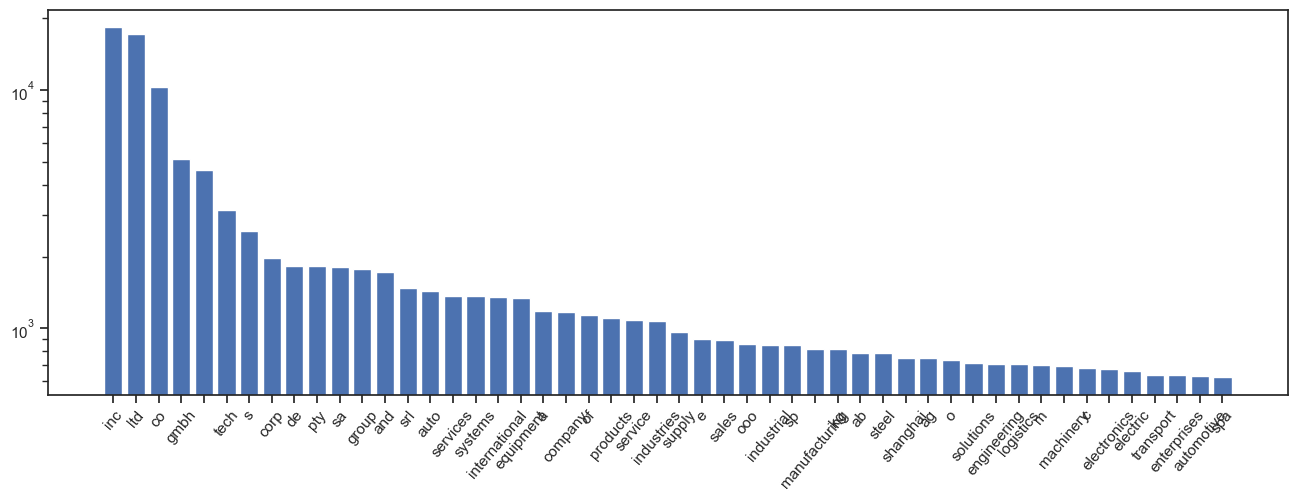

In [610]:
most_poluar_words = sorted(word_count_dict, key=word_count_dict.get, reverse=True)[0:50]
freq_most_polular_words = [word_count_dict[w] for w in most_poluar_words]

plt.figure(figsize=(16,5))
plt.bar(x = np.arange(len(most_poluar_words)),
        height = freq_most_polular_words,
        tick_label = most_poluar_words)
plt.yscale('log')
plt.xticks(rotation = 50)
plt.show()

### Checking short company names

In case the cleaning procedure deleted too much info

In [611]:
df_short =df_subset[df_subset['clean_entity_1'].apply(lambda x: len(str(x)) < 3) | 
                    df_subset['clean_entity_2'].apply(lambda x: len(str(x)) < 3)]

print(df_short.shape)

(12, 6)


In [612]:
df_short

,Unnamed: 0,entity_1,entity_2,tag,clean_entity_1,clean_entity_2
1024,6806292,beijing founder century information system che...,m.s,0,beijing founder century information system che...,ms
4008,8018014,"stellargroup Co.,ltd.",2E,0,stellargroup co ltd,2e
7410,1740093,hk,HK Co Ltd,1,hk,hk co ltd
20663,8518893,f.u,western fleet SErvices,0,fu,western fleet services
25887,7444244,Proactivesoft,bi,0,proactivesoft,bi
28098,5161848,C...M,logistics Company Limited,0,cm,logistics company ltd
34651,7266796,p...l,al-ko axis Inc.,0,pl,al ko axis inc
35720,8382968,v.g,guangzhou pro-technic machinery technology,0,vg,guangzhou pro technic machinery tech
37962,26527,8.d,8D LLC,1,8d,8d ltd
44847,4507985,a.t,at As,1,at,at as


### Feature engineering

Using classical edit distance metrics such as Levenshtrien and Jaro-Winkler, as well as RapidFuzz metrics, e.g. Token_Set_Ratio (Compares the words in the strings based on unique and common words between them), etc.

#### n-grams statistics

Calculated as intersection over union of n-grams

In [613]:
from collections import Counter

def get_n_gramm(s, n):
    # remove spaces
    s = re.sub(' +', ' ', s)
    if s[0] == ' ':
        s = s[1:]
    if s[-1] == ' ':
        s = s[0:len(s)-1]
    # add word_start and word_end
    words = s.split()
    new_s = ' '.join(['<' + w + '>' for w in  s.split()])
    return [new_s[i:i+n] for i in range(0,len(new_s)-n+1)]

def n_gram_iou(s1, s2, n):
    D1, D2 = Counter(get_n_gramm(s=s1, n=n)), Counter(get_n_gramm(s=s2, n=n))
    unity = D1 | D2
    intersection = D1 & D2
    return sum(intersection.values())/(sum(unity.values()))


print(n_gram_iou('d    gruppo motors srl', 'd de gruppo limitada motors resposabilidad ', n=1))
print(n_gram_iou('d gruppo motors srl', 'd de gruppo limitada motors resposabilidad', n=2))
print(n_gram_iou(' d gruppo motors srl', ' d de gruppo limitada motors resposabilidad', n=3))
print(n_gram_iou('d gruppo motors srl', 'd de gruppo limitada motors resposabilidad', n=4))

0.5
0.38596491228070173
0.375
0.36363636363636365


In [614]:
def generate_matrix_metrics(words1, words2, metric):
    set_words1 = list(set(words1) - set(['', ' ']))
    set_words2 = list(set(words2) - set(['', ' ']))
    m = np.zeros((len(set_words1), len(set_words2)))
    
    for i, w1 in enumerate(set_words1):
        for j, w2 in enumerate(set_words2):
            m[i,j] = metric(w1,w2)
    return m

In [615]:
def matrix_n_gram(s1, s2, n):
    # remove spaces
    s1, s2 = re.sub(' +', ' ', s1), re.sub(' +', ' ', s2)
    n_gram_subfunc = lambda s1, s2: n_gram_iou(s1, s2, n=n)
    m =  generate_matrix_metrics(words1=s1.split(' '), words2=s2.split(' '), metric=n_gram_subfunc)
    res = np.sum(m[m > 0.5])/(min(m.shape[0],m.shape[1]))
    return res.astype('float32')

print(matrix_n_gram('d gruppo motors srl', 'd depo limitada resposabilidad', n=1))

print(matrix_levenshtein('d gruppo motors srl', 'd de gruppo limitada motors resposabilidad'))

0.25
0.75


#### Edit distances

In [616]:
from Levenshtein import distance as levenshtein_distance
from jaro import jaro_winkler_metric
from fastDamerauLevenshtein import damerauLevenshtein
from rapidfuzz import fuzz, string_metric

#### converting all to numpy.float32 since python default float is actually 64 bits - to reduce daatframe size

In [617]:
def levenshtein(s1, s2): return np.float32(string_metric.normalized_levenshtein(s1,s2)/100)

def jaro_winkler(s1, s2): return np.float32(string_metric.jaro_winkler_similarity(s1, s2)/100)

def damer_lev(s1, s2): return np.float32(damerauLevenshtein(s1, s2))

def fuzz_ratio(s1, s2): return np.float32(fuzz.ratio(s1, s2)/100)

def part_ratio(s1, s2): return np.float32(fuzz.partial_ratio(s1, s2)/100)

def set_ratio(s1, s2): return np.float32(fuzz.token_set_ratio(s1, s2)/100)

def sort_ratio(s1, s2): return np.float32(fuzz.token_sort_ratio(s1, s2)/100)

def w_ratio(s1, s2): return np.float32(fuzz.WRatio(s1, s2)/100)


print(levenshtein('d gruppo motors srl', 'd de gruppo limitada motors resposabilidad'))
print(jaro_winkler('d gruppo motors srl', 'd de gruppo limitada motors resposabilidad'))
print(damer_lev('d gruppo motors srl', 'd de gruppo limitada motors resposabilidad'))
print(fuzz_ratio('d gruppo motors srl', 'd de gruppo limitada motors resposabilidad'))
print(part_ratio('d gruppo motors srl', 'd de gruppo limitada motors resposabilidad'))
print(set_ratio('d gruppo motors srl', 'd de gruppo limitada motors resposabilidad'))
print(sort_ratio('d gruppo motors srl', 'd de gruppo limitada motors resposabilidad'))
print(w_ratio('d gruppo motors srl', 'd de gruppo limitada motors resposabilidad'))

0.42857143
0.6946533
0.42857143
0.59016395
0.6315789
0.88235295
0.59016395
0.855


#### per-word thresholded metrics

In [618]:
def generate_matrix_metrics(words1, words2, metric):
    set_words1 = list(set(words1) - set(['', ' ']))
    set_words2 = list(set(words2) - set(['', ' ']))
    m = np.zeros((len(set_words1), len(set_words2)))
    
    for i, w1 in enumerate(set_words1):
        for j, w2 in enumerate(set_words2):
            m[i,j] = metric(w1,w2)
    return m

In [619]:
# jaro winkler
def matrix_jaro_winkler(s1, s2):
    m =  generate_matrix_metrics(words1=s1.split(' '), words2=s2.split(' '), metric=jaro_winkler)
    res = np.sum(m[m > 0.75])/(min(m.shape[0],m.shape[1]))
    return res.astype('float32')

#levenshtein
def matrix_levenshtein(s1, s2):
    m =  generate_matrix_metrics(words1=s1.split(' '), words2=s2.split(' '), metric=levenshtein)
    res = np.sum(m[m > 0.75])/(min(m.shape[0],m.shape[1]))
    return res.astype('float32')


print(matrix_jaro_winkler('de gruppo motors srl', 'grupp limitada motor resposabilidad'))
print(matrix_levenshtein('de gruppo motors srl', 'grupp limitada motor resposabilidad'))

0.48333332
0.41666666


#### double metaphone matrix similarity

In [620]:
from metaphone import doublemetaphone

def m_metaphone_jaro_winkler(w1, w2):
    metaphone1 = doublemetaphone(w1)[0]
    metaphone2 = doublemetaphone(w2)[0]
    return jaro_winkler(metaphone1, metaphone2)

#matrix  metaphone jaro_winkler
def matrix_metaphone(s1, s2):
    m =  generate_matrix_metrics(words1=s1.split(' '), words2=s2.split(' '), metric=m_metaphone_jaro_winkler)
    res = np.sum(m[m > 0.75])/(min(m.shape[0],m.shape[1]))
    return res.astype('float32')

In [621]:
print(matrix_metaphone('de gruppo motors srl', 'grupp limitada motor resposabilidad'))

0.48541665


### filling features into matrix

In [622]:
def generate_features_df(df_cleaned):
    df_cleaned['n_gram1'] = df_cleaned.apply(lambda x: n_gram_iou(x['clean_entity_1'], x['clean_entity_2'],n=1), axis=1)
    df_cleaned['n_gram2'] = df_cleaned.apply(lambda x: n_gram_iou(x['clean_entity_1'], x['clean_entity_2'],n=2), axis=1)
    df_cleaned['n_gram3'] = df_cleaned.apply(lambda x: n_gram_iou(x['clean_entity_1'], x['clean_entity_2'],n=3), axis=1)
    df_cleaned['n_gram4'] = df_cleaned.apply(lambda x: n_gram_iou(x['clean_entity_1'], x['clean_entity_2'],n=4), axis=1)  
    
    df_cleaned['M_n_gram1'] = df_cleaned.apply(lambda x: matrix_n_gram(x['clean_entity_1'], x['clean_entity_2'],n=1), axis=1)  
    df_cleaned['M_n_gram2'] = df_cleaned.apply(lambda x: matrix_n_gram(x['clean_entity_1'], x['clean_entity_2'],n=2), axis=1) 
    df_cleaned['M_n_gram3'] = df_cleaned.apply(lambda x: matrix_n_gram(x['clean_entity_1'], x['clean_entity_2'],n=3), axis=1)  
    
    df_cleaned['levenshtein'] = df_cleaned.apply(lambda x: levenshtein(x['clean_entity_1'], x['clean_entity_2']), axis=1)
    df_cleaned['jaro_winkler'] = df_cleaned.apply(lambda x: jaro_winkler(x['clean_entity_1'], x['clean_entity_2']), axis=1)
    df_cleaned['fuzz_ratio'] = df_cleaned.apply(lambda x: fuzz_ratio(x['clean_entity_1'], x['clean_entity_2']), axis=1)
    df_cleaned['part_ratio'] = df_cleaned.apply(lambda x: part_ratio(x['clean_entity_1'], x['clean_entity_2']), axis=1)
    df_cleaned['set_ratio'] = df_cleaned.apply(lambda x:   set_ratio(x['clean_entity_1'], x['clean_entity_2']), axis=1)
    df_cleaned['w_ratio'] = df_cleaned.apply(lambda x: w_ratio(x['clean_entity_1'], x['clean_entity_2']), axis=1)
    
    df_cleaned['M_jaro_winkler'] = df_cleaned.apply(lambda x: matrix_jaro_winkler(x['clean_entity_1'], x['clean_entity_2']), axis=1)
    df_cleaned['M_levenshtein'] = df_cleaned.apply(lambda x: matrix_levenshtein(x['clean_entity_1'], x['clean_entity_2']), axis=1)
    df_cleaned['M_metaphone'] = df_cleaned.apply(lambda x: matrix_metaphone(x['clean_entity_1'], x['clean_entity_2']), axis=1)
    

In [623]:
generate_features_df(df_subset)

In [624]:
features = ['n_gram1', 'n_gram2', 'n_gram3', 'n_gram4',
            'M_n_gram1', 'M_n_gram2', 'M_n_gram3',
            'levenshtein', 'jaro_winkler', 
            'fuzz_ratio', 'part_ratio', 'set_ratio', 'w_ratio',
            'M_jaro_winkler', 'M_levenshtein', 'M_metaphone',
            ]

In [625]:
df_subset.iloc[1000:].head(5)

,Unnamed: 0,entity_1,entity_2,tag,clean_entity_1,clean_entity_2,n_gram1,n_gram2,n_gram3,n_gram4,...,M_n_gram3,levenshtein,jaro_winkler,fuzz_ratio,part_ratio,set_ratio,w_ratio,M_jaro_winkler,M_levenshtein,M_metaphone
1000,2207937,Katcon Global Shanghai Emission Control System...,katcon global shanghai emission control,1,katcon global shanghai emission control system...,katcon global shanghai emission control,0.710145,0.705882,0.701493,0.696970,...,1.0,0.735849,0.947170,0.847826,1.000000,1.000000,0.950000,1.161905,1.000000,1.462000
1001,8336209,u.s 1 ustries,dkc SRO.,0,us 1 ustries,dkc sro,0.318182,0.080000,0.041667,0.000000,...,0.0,0.250000,0.448413,0.315789,0.428571,0.315789,0.385714,0.000000,0.000000,0.000000
1002,2959569,OwnEnergy Inc,ownenergy INC,1,ownenergy inc,ownenergy inc,1.000000,1.000000,1.000000,1.000000,...,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1003,7467238,Przedsiebiorstwo Produkcyjno Handlowo Uslugowe,changshu yuantong express delivery CoLtd,0,przedsiebiorstwo produkcyjno handlowo uslugowe,changshu yuantong express delivery co ltd,0.528571,0.105263,0.051020,0.010000,...,0.0,0.108696,0.579275,0.275862,0.324324,0.390805,0.371264,0.000000,0.000000,0.000000
1004,7925369,snappy sport SEnter,Professional Collision Center,0,snappy sport senter,professional collision center,0.538462,0.208333,0.120000,0.058824,...,0.0,0.344828,0.657794,0.500000,0.533333,0.458333,0.500000,0.296296,0.277778,0.592593


### Feature correlation

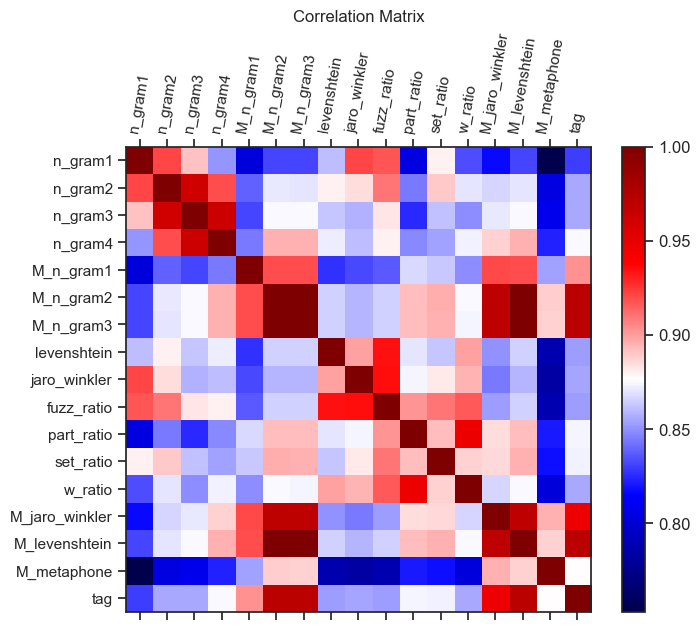

In [626]:
f = plt.figure(figsize=(8, 6))
plt.matshow(df_subset[features+['tag']].corr(method='spearman'), fignum=f.number, cmap='seismic')

plt.xticks(range(df_subset[features+['tag']].shape[1]),
           df_subset[features+['tag']].columns, fontsize=11, rotation=80)
plt.yticks(range(df_subset[features+['tag']].shape[1]),
           df_subset[features+['tag']].columns, fontsize=11)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)
plt.title('Correlation Matrix', fontsize=12)
plt.show()

In [627]:
df_small = df_subset.iloc[0:4000,::]
df_small.shape

(4000, 22)

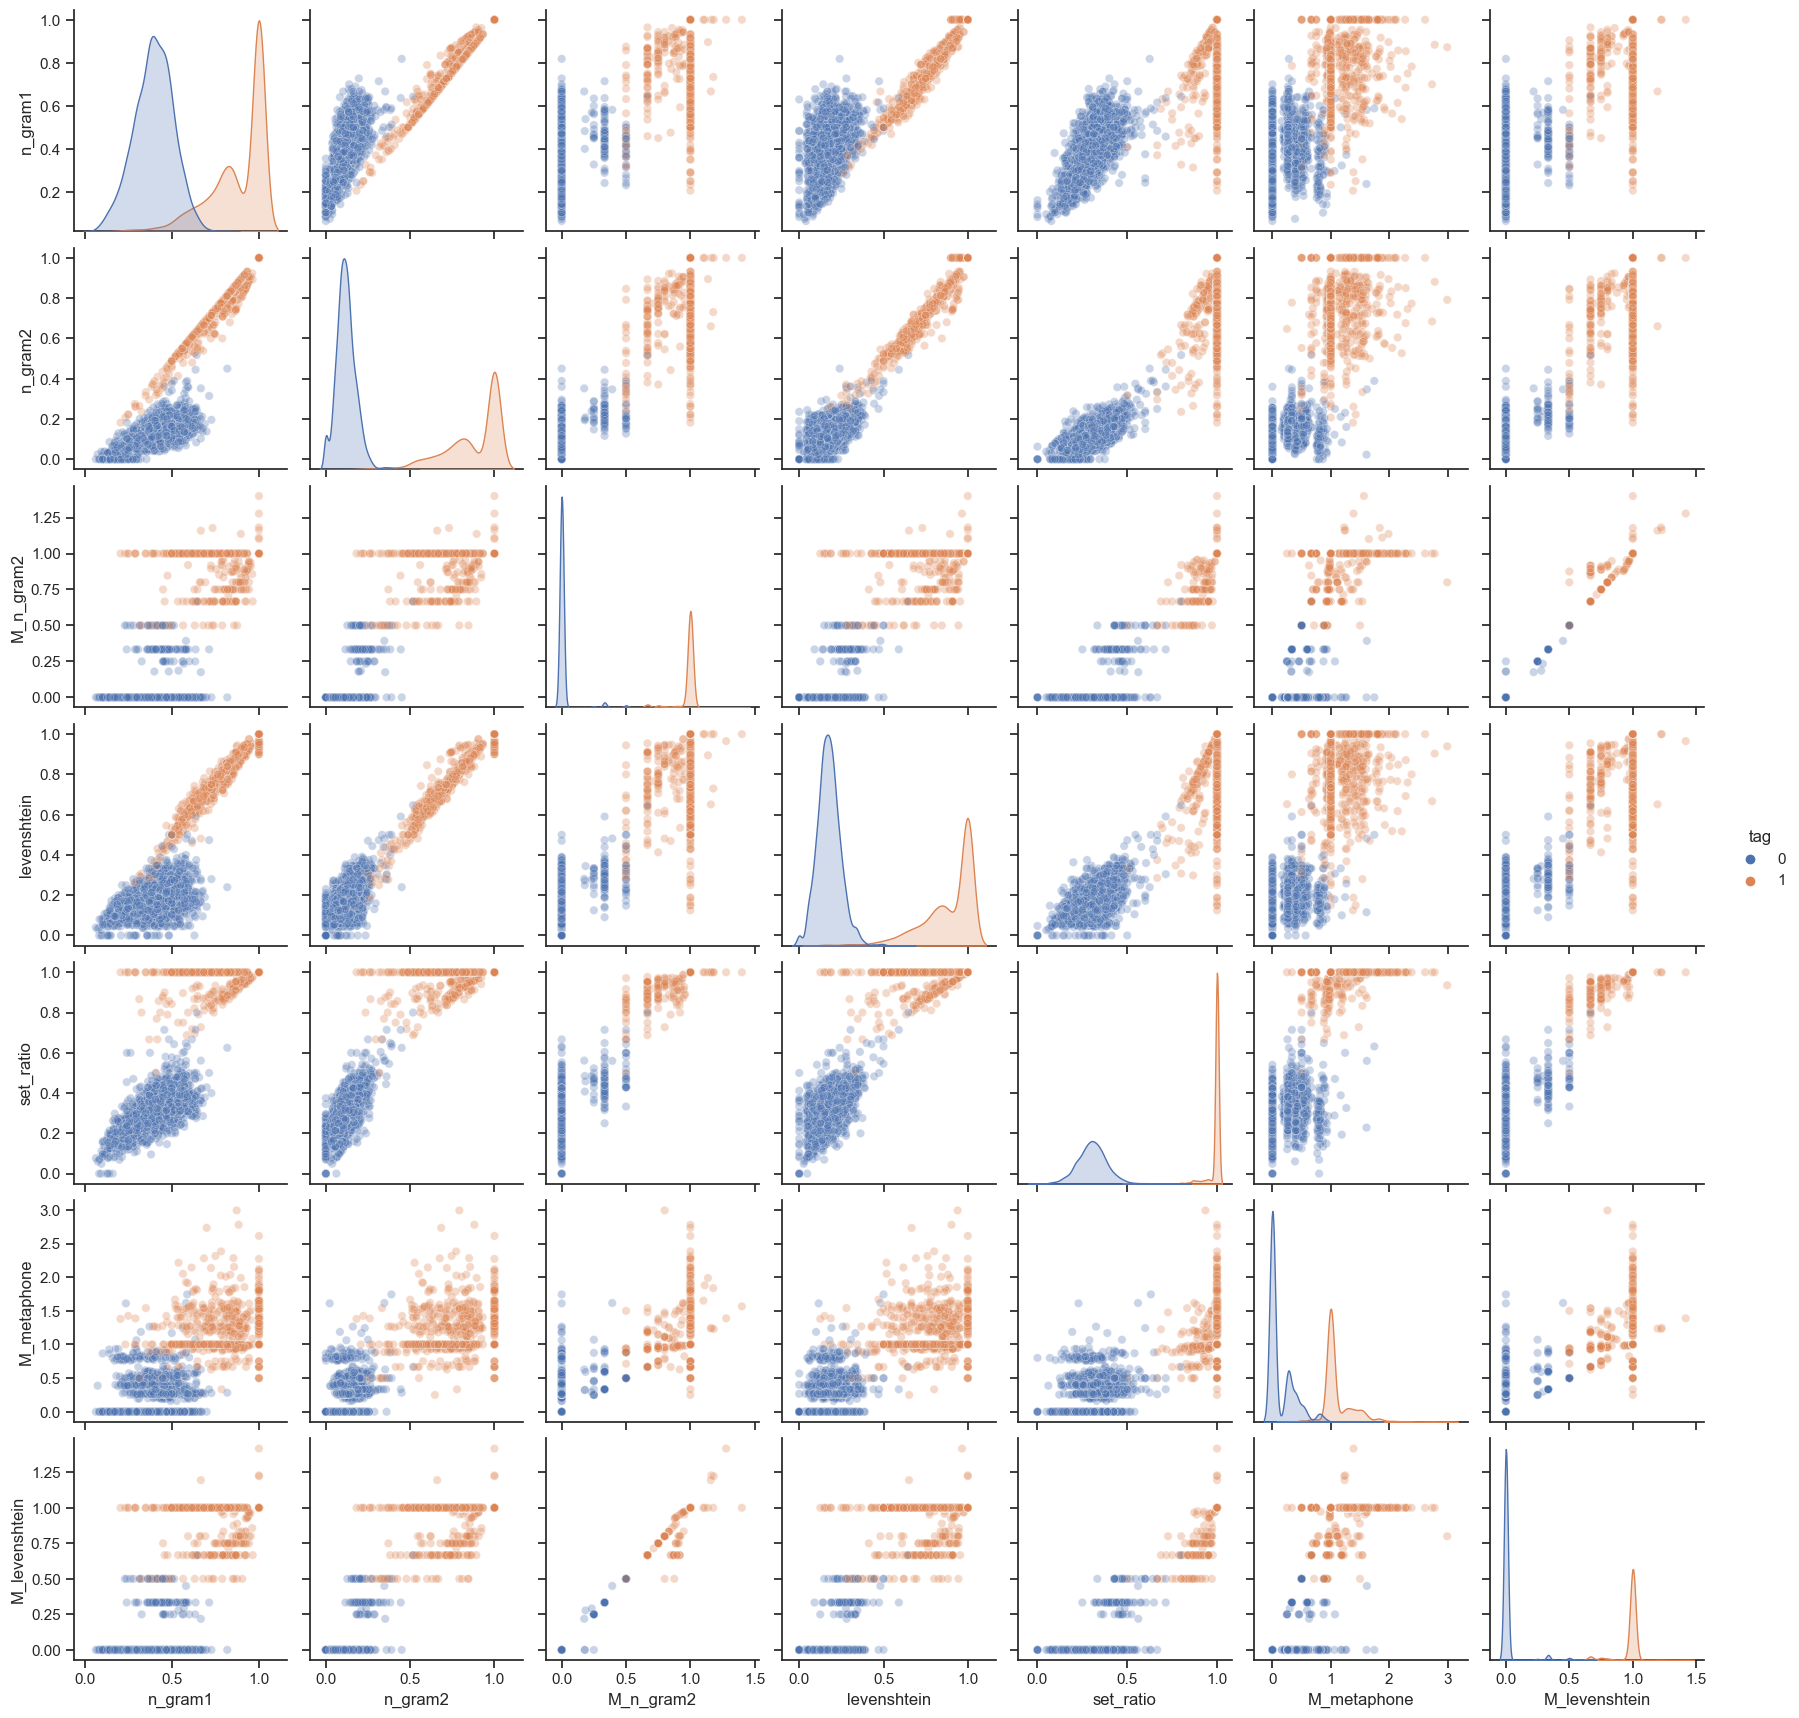

In [628]:
import seaborn as sns
sns.set_theme(style="ticks")

sub_features = ['n_gram1','n_gram2','M_n_gram2',
                'levenshtein',
                'set_ratio',
                'M_metaphone', 'M_levenshtein',
                'tag']

sns.pairplot(df_small[sub_features], hue="tag", plot_kws={'alpha':0.3})
plt.show()

## Testing performance on part of data

In [629]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, make_scorer

In [630]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [631]:
X_t, Y_t = df_subset[features], df_subset['tag']

In [632]:
LogReg = LogisticRegression(random_state=42, class_weight="balanced")

precision = cross_val_score(LogReg, X_t, Y_t, cv=5, scoring=make_scorer(precision_score))
recall = cross_val_score(LogReg, X_t, Y_t, cv=5, scoring=make_scorer(recall_score))

print(f'precision = {np.round(np.mean(precision),6)} +/- {np.round(np.std(precision),6)}')
print(f'recall = {np.round(np.mean(recall),6)} +/- {np.round(np.std(recall),6)}')

precision = 0.999314 +/- 0.00024
recall = 0.999021 +/- 0.00041


In [633]:
RandFor = RandomForestClassifier(n_estimators=50, max_depth=10,
                                 min_samples_split=5,  min_samples_leaf=1,
                                 class_weight='balanced',
                                 random_state=1)

precision = cross_val_score(RandFor, X_t, Y_t, cv=5, scoring=make_scorer(precision_score))
recall = cross_val_score(RandFor, X_t, Y_t, cv=5, scoring=make_scorer(recall_score))

print(f'precision = {np.round(np.mean(precision),6)} +/- {np.round(np.std(precision),6)}')
print(f'recall = {np.round(np.mean(recall),6)} +/- {np.round(np.std(recall),6)}')

precision = 0.999804 +/- 0.000183
recall = 0.99951 +/- 0.000268


## Breaking dataset in parts to avoid MemoryError

### saving - quite long process, generates around 1.2 GB of csv files

In [103]:
df = pd.read_csv(data_path + 'ds_challenge_alpas.csv')

In [104]:
step_size = df.shape[0]//20
data_index_range = np.arange(0, df.shape[0]-step_size, step_size)

for i, data_index in enumerate(data_index_range):
    print(i, end=' ')
    df_subset = df.iloc[data_index : data_index + step_size]
    clean_columns_df(df_subset)
    generate_features_df(df_subset)
    
    df_subset.to_csv(data_path + f'ds_challenge_alpas_features_{i}.csv')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

### loading

In [106]:
DATA_DICT = {}
for i in range(20):
    DATA_DICT[i] = pd.read_csv(data_path + f'ds_challenge_alpas_features_{i}.csv')

### Training and evaluating models

Since we are requested to predict probability of the names being same entity, we can use limited number of models that provide such probability. I selected
- Logistic Regression
- Random Forest
- Naive Bayes
- Feedforward Neural Network (Multilayer Perceptron)


### Clean and generate features for train, test and validation

In [107]:
from sklearn.model_selection import train_test_split

#### Instead of classical Cross-Validation, since amount of data is pretty high, I'll run training on one saved sub-portion of data and testing on the other

In [108]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, make_scorer

In [120]:
features = ['levenshtein', 'jaro_winkler', 
            'fuzz_ratio', 'part_ratio', 'set_ratio', 'w_ratio',
            'm_jaro_winkler', 'm_levenshtein', 'm_metaphone',
            'n_gram1', 'n_gram2', 'n_gram3']

In [121]:
def manual_cv_scoring(clf):
    # splitting indexes of datasets
    train_matrix, test_indexes = train_test_split(np.arange(20), test_size=0.25)
    train_matrix = train_matrix.reshape((5,3))

    precision_scores = []
    recall_scores = []

    for test_index, train_indexes in zip(test_indexes, train_matrix):
        data_train = []
        for indx in train_indexes:
            data_train.append(DATA_DICT[indx])
        df_train = pd.concat(data_train)

        X_train, Y_train = df_train[features], df_train['tag']
        X_test, Y_test = DATA_DICT[test_index][features], DATA_DICT[test_index]['tag']

        clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)

        precision, recall = precision_score(Y_test, Y_pred), recall_score(Y_test, Y_pred)
        precision_scores.append(precision)
        recall_scores.append(recall)
        
    return precision_scores, recall_scores

In [122]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.decomposition import PCA

In [123]:
LogReg = LogisticRegression(random_state=1, class_weight="balanced")
RandFor = RandomForestClassifier(n_estimators=50, max_depth=10, criterion='gini',
                                 min_samples_split=5,  min_samples_leaf=1,
                                 class_weight='balanced',
                                 random_state=1)
MLP = MLPClassifier(hidden_layer_sizes=(64,128,64), random_state=1)
GNB = GaussianNB()

### Evaluation

Since we got binary classification with (almost) balanced classes, all standart metrics such as accuracy, precision, recall and f1 
I selected precision - recall

In order to test actual accuracy of the model I performed k-fold Cross-Validation 

### logistic regression

In [124]:
precision_scores, recall_scores = manual_cv_scoring(LogReg)
print(f'precision = {np.round(np.mean(precision_scores),6)} +/- {np.round(np.std(precision_scores),6)}')
print(f'recall = {np.round(np.mean(recall_scores),6)} +/- {np.round(np.std(recall_scores),6)}')

precision = 0.998572 +/- 0.000124
recall = 0.998953 +/- 6.5e-05


### naive bayes

In [125]:
precision_scores, recall_scores = manual_cv_scoring(GNB)
print(f'precision = {np.round(np.mean(precision_scores),6)} +/- {np.round(np.std(precision_scores),6)}')
print(f'recall = {np.round(np.mean(recall_scores),6)} +/- {np.round(np.std(recall_scores),6)}')

precision = 0.998292 +/- 8.8e-05
recall = 0.998062 +/- 0.000101


### random forest

In [126]:
precision_scores, recall_scores = manual_cv_scoring(RandFor)
print(f'precision = {np.round(np.mean(precision_scores),6)} +/- {np.round(np.std(precision_scores),6)}')
print(f'recall = {np.round(np.mean(recall_scores),6)} +/- {np.round(np.std(recall_scores),6)}')

precision = 0.99906 +/- 3.9e-05
recall = 0.99936 +/- 5.3e-05


### feedforward neural network

In [127]:
precision_scores, recall_scores = manual_cv_scoring(MLP)
print(f'precision = {np.round(np.mean(precision_scores),6)} +/- {np.round(np.std(precision_scores),6)}')
print(f'recall = {np.round(np.mean(recall_scores),6)} +/- {np.round(np.std(recall_scores),6)}')

precision = 0.998703 +/- 0.000479
recall = 0.999156 +/- 0.000356


### Exploring wrong predictions (using LogReg)

In [128]:
X, Y = DATA_DICT[10][features], DATA_DICT[10]['tag']
X_test, Y_test = DATA_DICT[5][features], DATA_DICT[5]['tag']
df_test = DATA_DICT[5]

In [129]:
LogReg = LogisticRegression(random_state=1, class_weight="balanced")
clf = LogReg.fit(X, Y)

In [130]:
Y_pred = clf.predict(X_test)

In [131]:
df_wrong_predictions = df_test[(Y_test == 1) & (Y_pred == 0)]
df_wrong_predictions.head(50)

,Unnamed: 0.1,Unnamed: 0,entity_1,entity_2,tag,clean_entity_1,clean_entity_2,levenshtein,jaro_winkler,fuzz_ratio,part_ratio,set_ratio,w_ratio,m_jaro_winkler,m_levenshtein,m_metaphone,n_gram1,n_gram2,n_gram3,n_gram4
637,1761347,4467703,Zetatrans ad Podgorica,zetatrans aktsionerno drujestvo,1,ad podgorica zetatrans,aktsionerno drujestvo zetatrans,0.451613,0.636450,0.528302,0.666667,0.580645,0.551613,0.333333,0.333333,0.595238,0.547619,0.312500,0.244898,0.204082
862,1761572,2321916,La Spa OU,la Sociedad por acciones,1,la ou spa,acciones la por sociedad,0.291667,0.574074,0.424242,0.666667,0.424242,0.855000,0.333333,0.333333,0.586667,0.424242,0.216216,0.162162,0.108108
933,1761643,1745975,HVM A/S,hvm Aktieselskab,1,a hvm s,aktieselskab hvm,0.187500,0.427579,0.434783,0.769231,0.600000,0.855000,0.500000,0.500000,0.500000,0.434783,0.291667,0.208333,0.173913
5571,1766281,502312,beardow a.n.d aktsionerno drujestvoams,Beardow and Adams (Adhesives) Ltd,1,aktsionerno and beardow drujestvoams,adams adhesives and beardow ltd,0.361111,0.622081,0.537313,0.642857,0.597015,0.567164,0.500000,0.500000,0.880060,0.634615,0.406780,0.306452,0.274194
6625,1767335,2615785,metalsa Sociedade anônima,Metalsa SA de CV,1,anonima metalsa sociedade,cv de metalsa sa,0.440000,0.557651,0.536585,0.687500,0.608696,0.855000,0.333333,0.333333,0.591667,0.571429,0.432432,0.342105,0.289474
8566,1769276,1040981,DRM Sales and Supply LLC,drm Sociedade anônimales and,1,and drm ltd sales supply,and anonimales drm sociedade,0.285714,0.599206,0.423077,0.512821,0.538462,0.511538,0.500000,0.500000,0.500000,0.489362,0.387755,0.346939,0.306122
8831,1769541,3381225,Rotor doo Zemun,rotor društvo s ograničenom odgovornošću,1,doo rotor zemun,drustvo odgovornoscu ogranicenom rotor s,0.225000,0.618254,0.363636,0.640000,0.500000,0.855000,0.333333,0.333333,0.853333,0.392157,0.210526,0.175439,0.160714
10283,1770993,1582139,garris Sociedade anônimales,Garris Sales and Service,1,anonimales garris sociedade,and garris sales service,0.333333,0.691439,0.509804,0.553191,0.666667,0.633333,0.333333,0.333333,0.333333,0.666667,0.431818,0.355556,0.311111
15711,1776421,3818837,strattec Societas Europaeacurity,Strattec Security Corp,1,europaeacurity societas strattec,corp security strattec,0.531250,0.774621,0.666667,0.700000,0.666667,0.666667,0.333333,0.333333,0.601667,0.736842,0.454545,0.409091,0.363636
15817,1776527,3248710,RMB Sateci SAC,rmb Société anonymeteci,1,rmb sac sateci,anonymeteci rmb societe,0.217391,0.549689,0.432432,0.640000,0.540540,0.855000,0.333333,0.333333,0.333333,0.580645,0.382353,0.285714,0.194444


In [132]:
df_wrong_predictions = df_test[(Y_test == 0) & (Y_pred == 1)]
df_wrong_predictions.head(50)

,Unnamed: 0.1,Unnamed: 0,entity_1,entity_2,tag,clean_entity_1,clean_entity_2,levenshtein,jaro_winkler,fuzz_ratio,part_ratio,set_ratio,w_ratio,m_jaro_winkler,m_levenshtein,m_metaphone,n_gram1,n_gram2,n_gram3,n_gram4
3095,1763805,7273859,DOSB N.e.w Media GmbH,pt media,0,dosb gmbh media new,media pt,0.315789,0.399854,0.444444,0.750000,0.769231,0.855000,0.500000,0.500000,0.500000,0.344828,0.275862,0.250000,0.222222
3694,1764404,5311006,alphamatic systems sdn. Berhad.,cisco systems,0,alphamatic berhad sdn systems,cisco systems,0.344828,0.505416,0.476190,0.761905,0.700000,0.855000,0.500000,0.500000,0.500000,0.384615,0.238095,0.219512,0.200000
7546,1768256,8535325,pebco i.n.c,wilco inc,0,inc pebco,inc wilco,0.666667,0.866667,0.666667,0.666667,0.666667,0.666667,0.500000,0.500000,0.900000,0.625000,0.500000,0.375000,0.250000
9948,1770658,6802787,av engineering services LTD,mol engineering,0,av engineering ltd services,engineering mol,0.444444,0.654511,0.619048,0.866667,0.846154,0.855000,0.500000,0.500000,0.500000,0.459459,0.368421,0.351351,0.333333
10117,1770827,5937285,g-tech international Co. Ltd...,"raiden CO.,LTD.",0,co g international ltd tech,co ltd raiden,0.296296,0.629975,0.450000,0.600000,0.631579,0.855000,0.666667,0.666667,1.000000,0.473684,0.255814,0.238095,0.219512
10300,1771010,8326141,Zentner Transportation Inc,turo INC.,0,inc transportation zentner,inc turo,0.269231,0.828846,0.411765,0.857143,0.545455,0.855000,0.500000,0.500000,0.896296,0.333333,0.200000,0.176471,0.151515
10473,1771183,4893778,autook sociedad de,indios shoes Sociedad de,0,autook de sociedad,de indios shoes sociedad,0.500000,0.644180,0.571429,0.733333,0.758621,0.720690,0.666667,0.666667,0.666667,0.555556,0.421053,0.368421,0.315789
10547,1771257,8177213,tellurian technologies Inc,lantos technologies Inc.,0,inc tech tellurian,inc lantos tech,0.277778,0.690572,0.484849,0.695652,0.727273,0.690909,0.666667,0.666667,0.666667,0.730769,0.482759,0.366667,0.300000
12163,1772873,6426776,laser systems inc,jpr systems INC.)),0,inc laser systems,inc jpr systems,0.705882,0.705222,0.787879,0.750000,0.846154,0.812500,0.666667,0.666667,0.666667,0.760000,0.680000,0.600000,0.520000
15396,1776106,7993575,ssg Inc.,S.s.i Technology Inc,0,inc ssg,inc ssi tech,0.500000,0.871429,0.631579,0.923077,0.631579,0.855000,0.911111,0.500000,0.925000,0.526316,0.421053,0.388889,0.352941


In [133]:
df_wrong_predictions.shape

(211, 20)

### Conclusion

There are main errors done by model:
1. False Positives: 
- when two different companies got same additions like "Incorporated, Systems, Solutions, Technologies" etc in the name and relatively short actual company names (e.g. "yasuda instrument Co" -  "leader instruments corp") - can be fixed by removing such common additions or weighted edit distance metrics (need custom NERC and non-named additions will get less weight)
2. False Negatives 
- when name of the company is translated to other language (can apply language detection and translation)
- when one of entities uses abbreviations and other doesn't - can be fixed by keeping a dictionary for unpacking common abbreviations

Typos in the company names, which can be fixed by running a spellchecker on entities with low NERC probability


#### Deployment

The best metrics are achieved by RandomForest and FeedForward NN, but they are quite slow both in training and inference.
So I would apply LogReg or NaiveBayes for this task.

Good approach would be to have feedback loop - to provide the end user the ability to fix wrong predictions. Both LogReg and NaiveBayes can be updated without retraining - which is a big plus. However since the initial dataset is such vast (over 7 million datapoints) I'd reccomend keeping feedback in a separate dataset for separate model.


### Probability prediction

In [48]:
import pickle

In [49]:
X, Y = DATA_DICT[1][features], DATA_DICT[1]['tag']
X_test, Y_test = DATA_DICT[12][features], DATA_DICT[12]['tag']

LogReg = LogisticRegression(random_state=1, class_weight="balanced")
clf = LogReg.fit(X, Y)

In [50]:
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(clf, open(data_path + filename, 'wb'))

In [51]:
# load the model from disk
loaded_model = pickle.load(open(data_path + filename, 'rb'))
Y_probabilities = loaded_model.predict_proba(X_test)[::,1]

In [52]:
print(Y_probabilities[0:5])

[1.01024247e-06 9.99995504e-01 9.99989639e-01 9.99949245e-01
 9.99897209e-01]


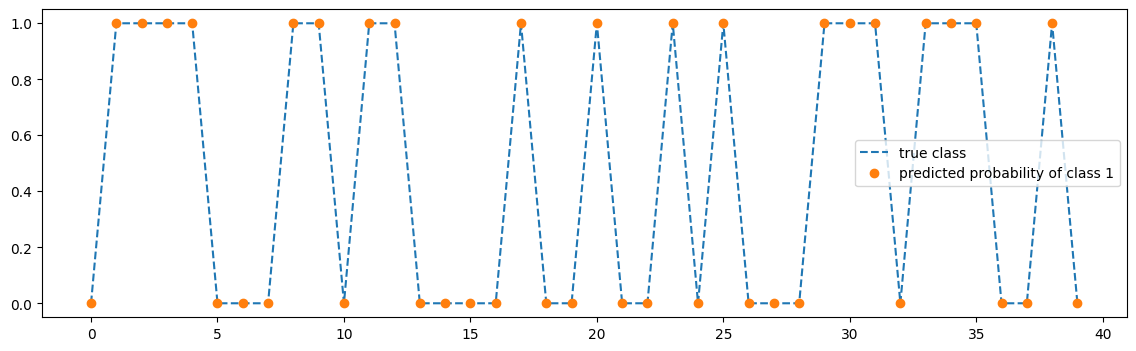

In [53]:
plt.figure(figsize=(14,4))
plt.plot(Y_test.iloc[0:40], '--', label = 'true class')
plt.plot(Y_probabilities[0:40], 'o', label='predicted probability of class 1')
plt.legend()
plt.show()